In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
import qutip
from scipy.linalg import sqrtm

from povm_clf import *

from sympy.physics.quantum.circuitplot import CircuitPlot,CreateOneQubitGate
from sympy.physics.quantum.gate import *

---
# 1. Functions in povm_clf

## 1-1. Two-Qubit State Preparation

In [195]:
two_bloch_vecs = [[0,0,1],[1,0,0]]

#### Circuit Diagram

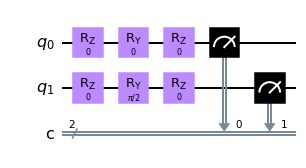

In [196]:
dev_qiskit = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev_qiskit)
def circ_test():
    for i, vec in enumerate(two_bloch_vecs):
        State_Preparation(vec).state_prepared_on_circuit(wires=i)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

## 1-2. (Controlled) Universal Two-Qubit Gates

### Universal Two-Qubit Gates, SU(4)

In [14]:
def SU4(params, wires):
    # two-qubit SU(4) gates designed by V. V. Shende et al., PRA 69 062321 (2004)
    qml.Rot(params[0], params[1], params[2], wires=wires[0])
    qml.Rot(params[3], params[4], params[5], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(params[6], wires=wires[0])
    qml.RY(params[7], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RY(params[8], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])

    qml.Rot(params[9], params[10], params[11], wires=wires[0])
    qml.Rot(params[12], params[13], params[14], wires=wires[1])

#### - Circuit Diagram

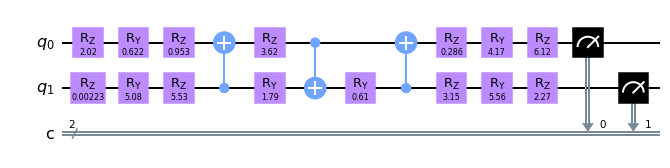

In [19]:
dev_qiskit = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([15])
    SU4(params, wires=[0,1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

### Uniformly CCRY gate

In [ ]:
def CCRY(phi, wires):
    # 
    phi = phi/2
    qml.CRY(phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY((-1)*phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY(phi, wires=[wires[0], wires[2]])

def UCCRY(params, wires):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    CCRY(phi=params[0], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[1])
    qml.PauliX(wires=wires[0])
    
    qml.PauliX(wires=wires[0])
    CCRY(phi=params[1], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[0])

    qml.PauliX(wires=wires[1])
    CCRY(phi=params[2], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[1])

    CCRY(phi=params[3], wires=[wires[0], wires[1], wires[2]])

#### - Circuit Diagram

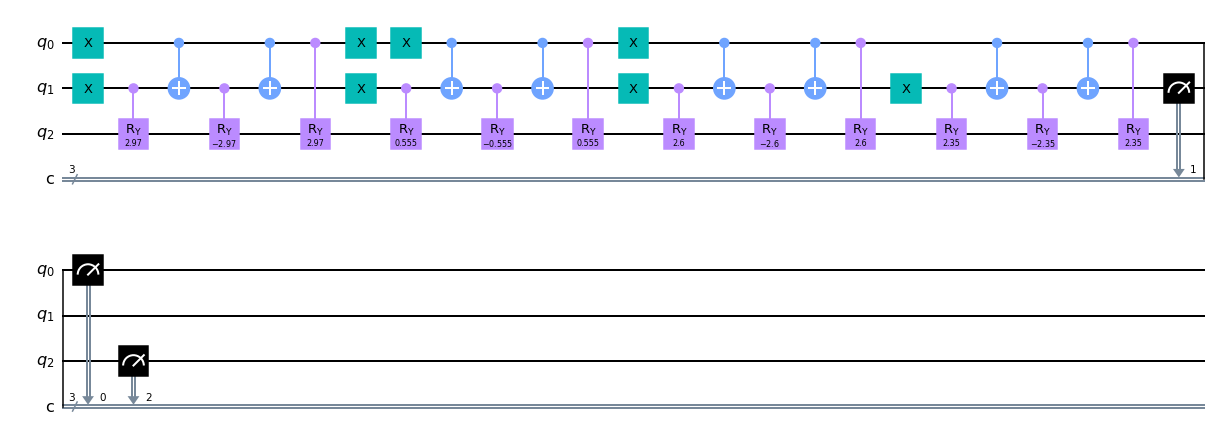

In [ ]:
dev_qiskit = qml.device("qiskit.aer", wires=3)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([4])
    UCCRY(params, wires=[0,1,2])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

### Two-element Two-qubit POVM Module

In [164]:
def two_element_povm(params, wires):
    SU4(params[:15], wires=[wires[0],wires[1]])
    UCCRY(params[15:19], wires=[wires[0],wires[1],wires[2]])

#### - Circuit Diagram

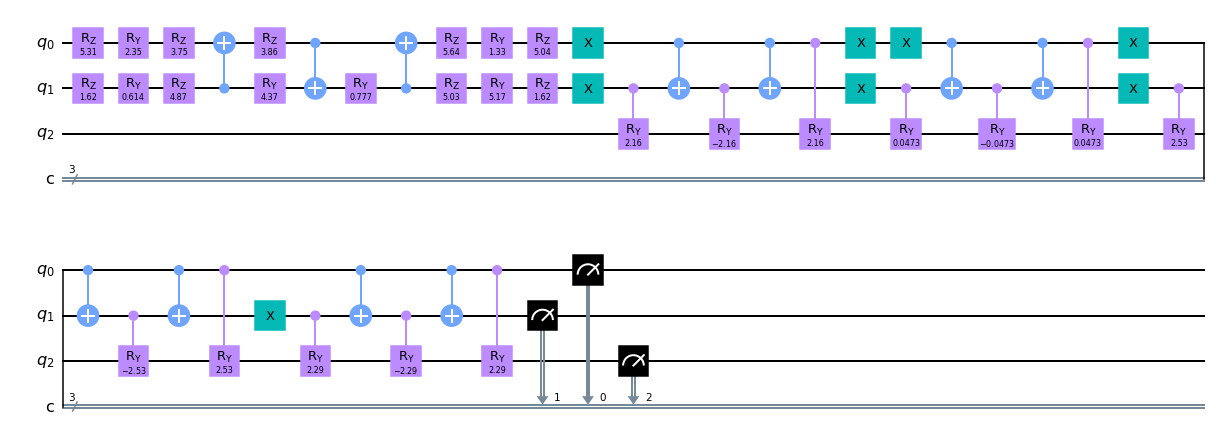

In [157]:
dev_qiskit = qml.device("qiskit.aer", wires=3)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([19])
    two_element_povm(params, wires=[0,1,2])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

### Controlled two-element POVM

In [159]:
def C2ePOVM(params, wires):
    ctrl_2ePOVM = qml.ctrl(two_element_povm, control=wires[0])
    ctrl_2ePOVM(params, wires=[wires[1],wires[2],wires[3]])

#### - Circuit Diagram

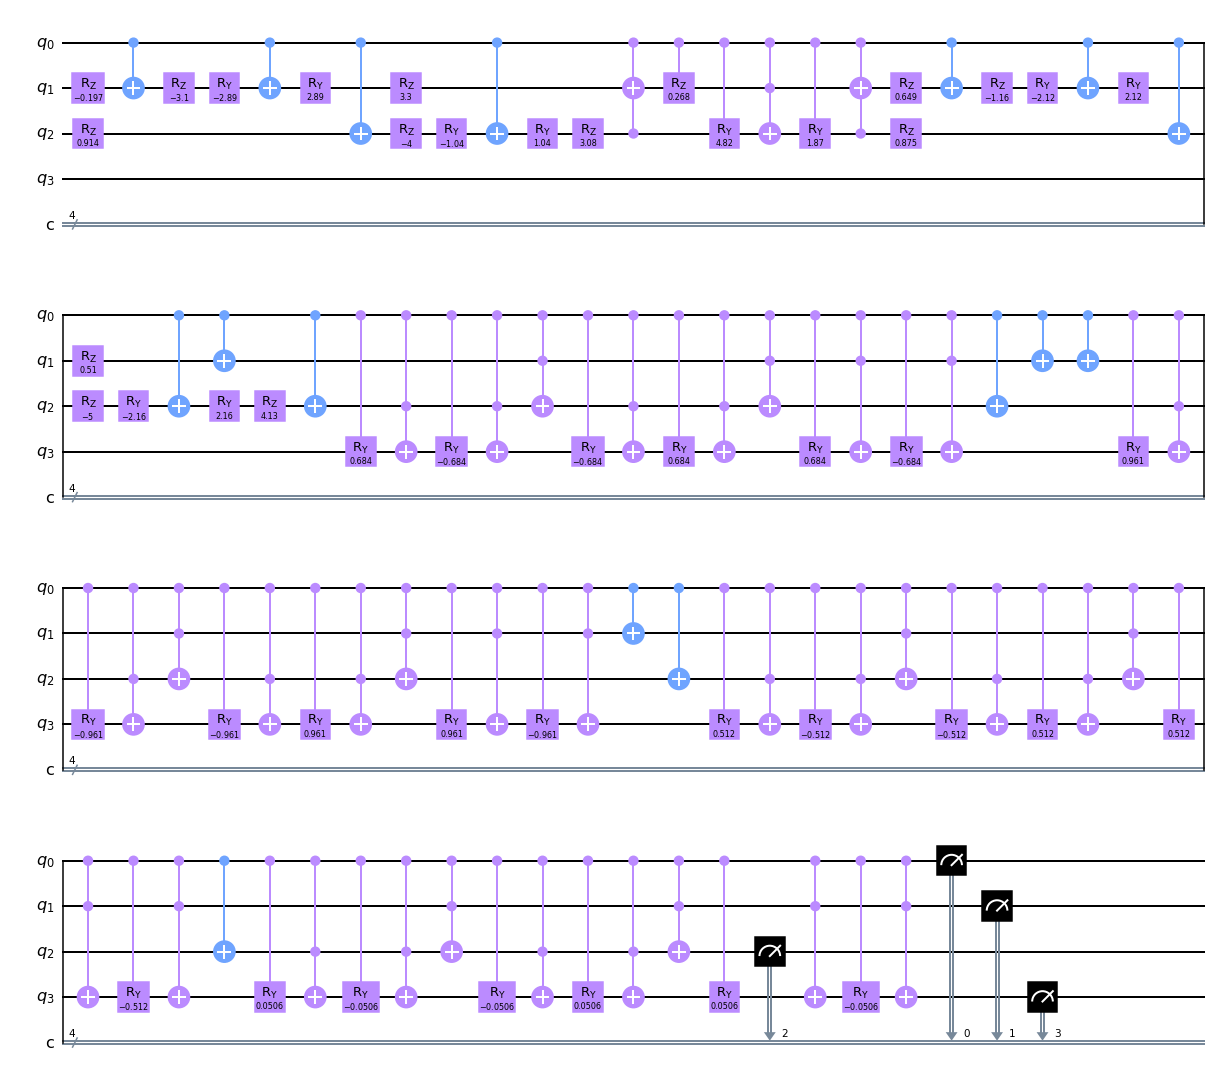

In [162]:
dev_qiskit = qml.device("qiskit.aer", wires=4)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([19])
    C2ePOVM(params, wires=[0,1,2,3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

## 1-3. Four-element POVMs for two qubits

In [2]:
def four_element_povm(params, wires):
    two_element_povm(params[:19], wires=[wires[0],wires[1],wires[2]])
    qml.PauliX(wires=wires[2])
    C2ePOVM(params[19:38], wires=[wires[2],wires[0],wires[1],wires[3]])
    qml.PauliX(wires=wires[2])
    C2ePOVM(params[38:], wires=[wires[2],wires[0],wires[1],wires[3]])

#### - Circuit Diagram

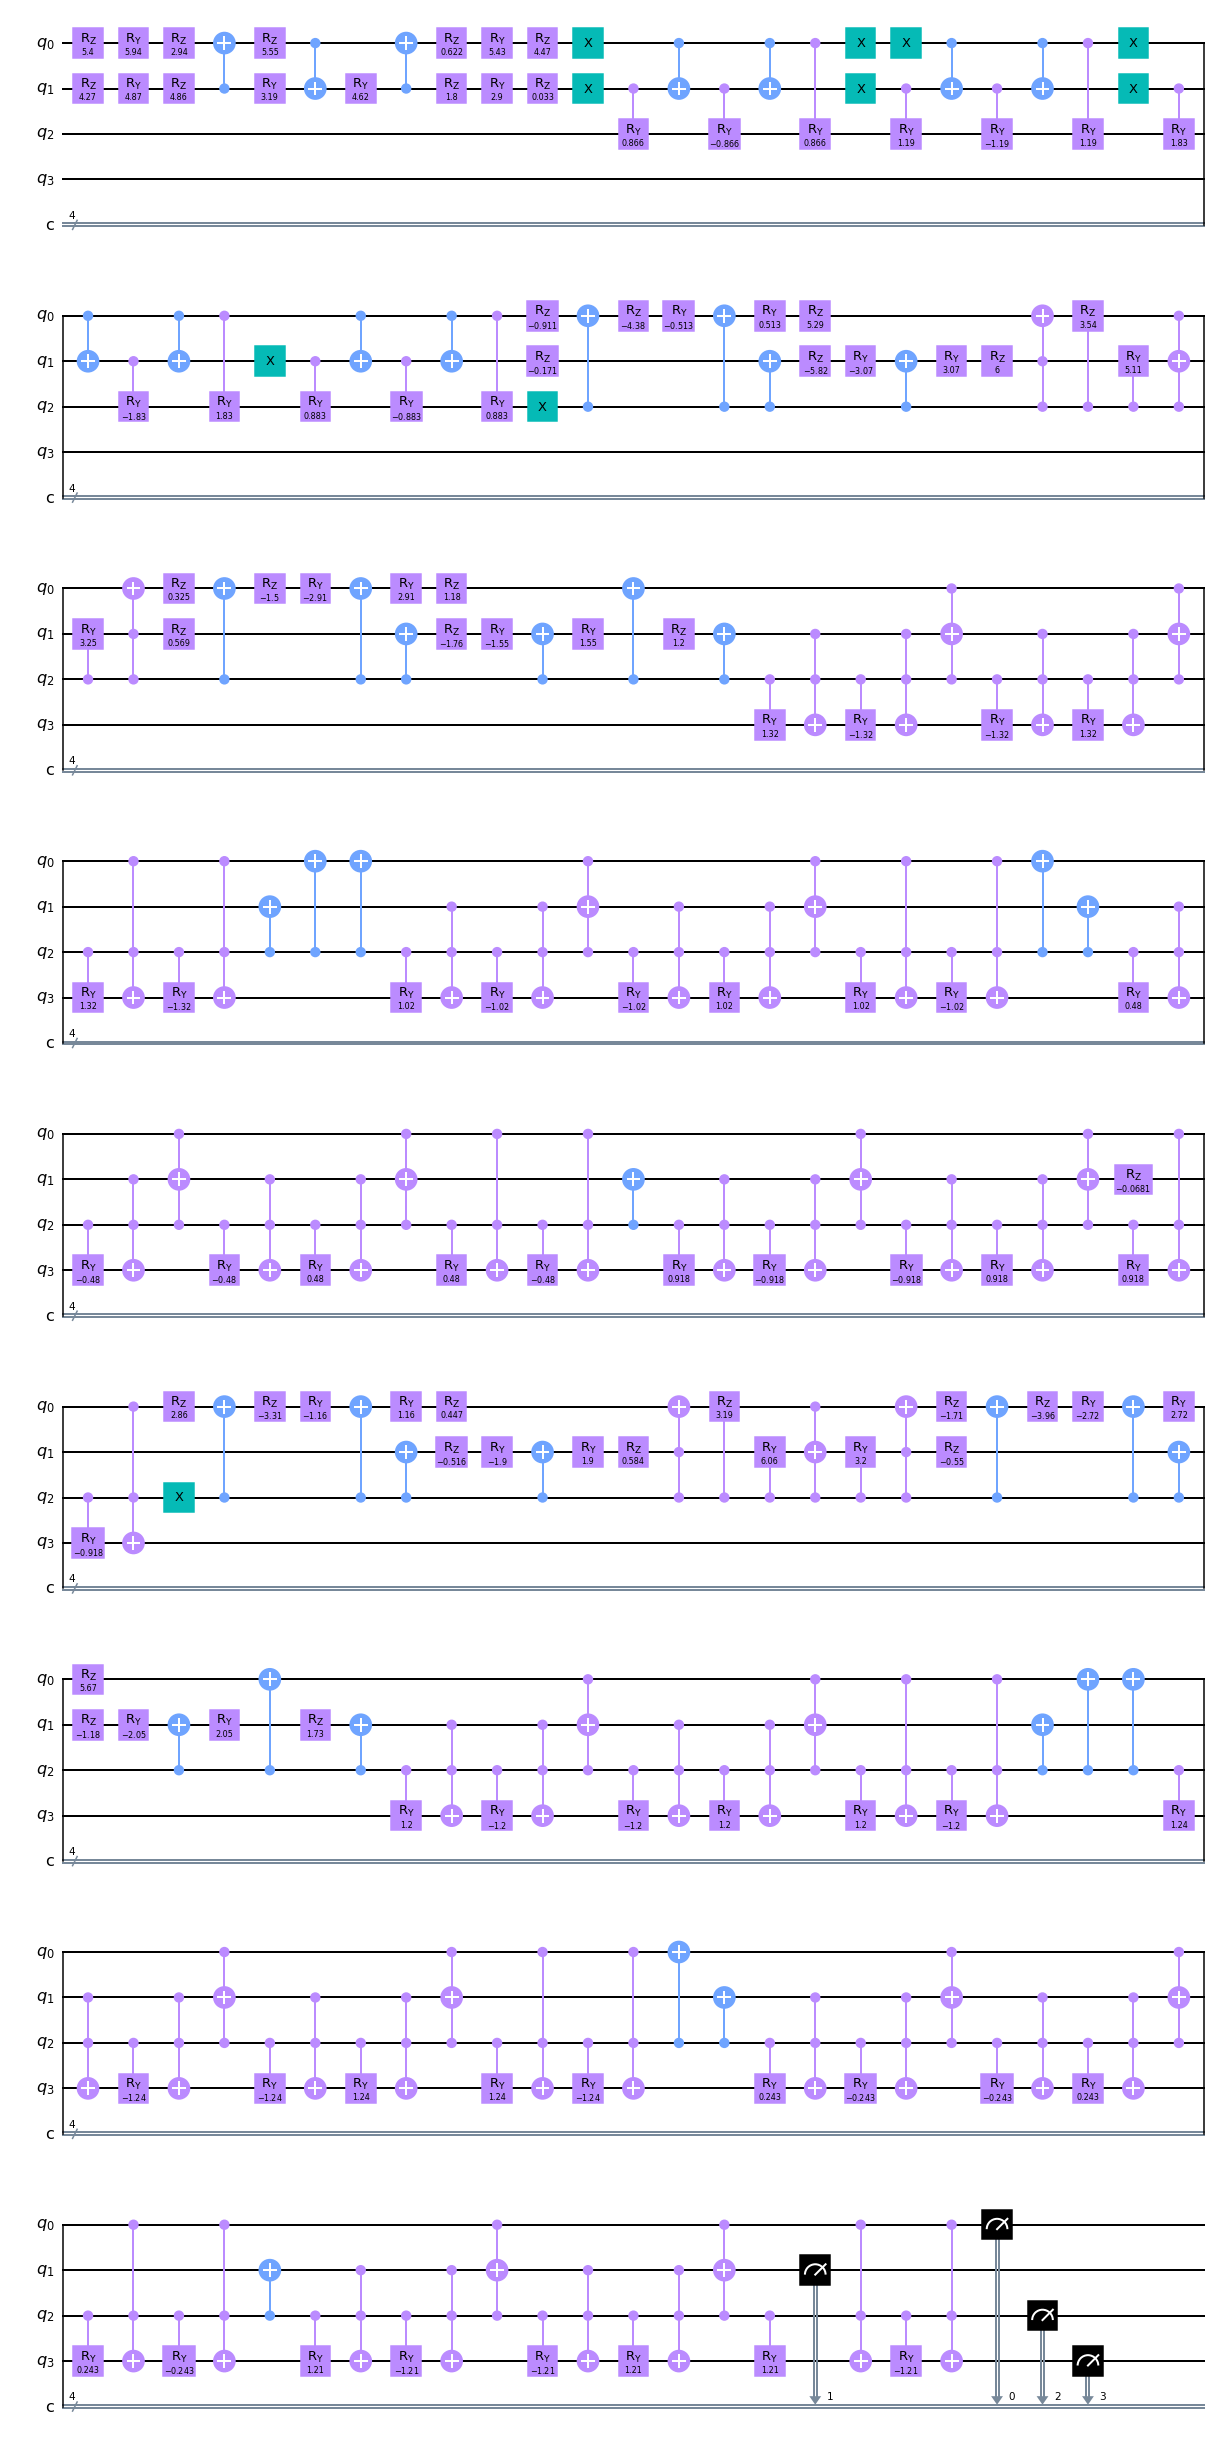

In [175]:
dev_qiskit = qml.device("qiskit.aer", wires=4)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([57])
    four_element_povm(params, wires=[0,1,2,3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

---
# 2. Pure-state Classifier

##  Two-element POVM

In [8]:
n = 4
devs = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2, 3]
a_priori_probs = [1/n] * n

two_bloch_vecs = [[0,0,1], [1,0,0]]
dev = qml.device('default.qubit', wires=n)

In [19]:
povm_circ = TwoQubitPOVM(n=4, two_bloch_vecs=two_bloch_vecs)
qnode = povm_circ(wires, dev)
qnodes = qml.QNodeCollection([qnode])

In [14]:
params = 2* np.pi * np.random.random([57])

In [20]:
qnodes(params)

array([[0.49399011, 0.36842362, 0.08564483, 0.05194144]])

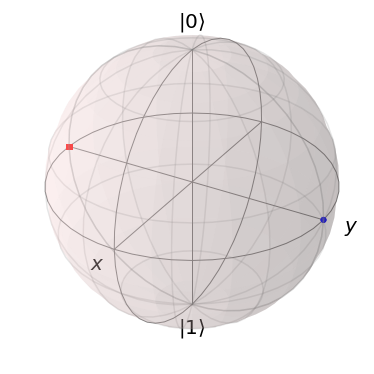

In [10]:
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [21]:
classifier = POVM_clf(2, wires, dev, a_priori_probs, bloch_vecs)
Helstrom_bound = classifier.spectral_decomp()
print(Helstrom_bound)

0.0


In [17]:
steps=200
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4987660
Cost after step    20:  0.4956657
Cost after step    40:  0.4679395
Cost after step    60:  0.1067236
Cost after step    80:  0.0015750
Cost after step   100:  0.0000233
Cost after step   120:  0.0000003
Cost after step   140:  0.0000000
Cost after step   160:  0.0000000
Cost after step   180:  0.0000000
Cost after step   200:  0.0000000


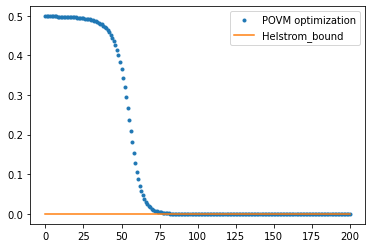

In [18]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound]*(steps+1), '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [19]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.9999999999999836
performed PGM: 2.220446049250313e-16


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.0000-0.5000j,0.5000+0.0000j,0.0000+0.5000j,,0.5000+0.0000j,0.0000-0.5000j,
,0.0000+0.5000j,0.5000+0.0000j,0.0000-0.5000j,0.5000+0.0000j,0.0000,0.0000+0.5000j,0.5000+0.0000j,1.0000
i=1,0.5000+0.0000j,0.0000+0.5000j,0.5000+0.0000j,-0.0000-0.5000j,,0.5000+0.0000j,0.0000+0.5000j,
,0.0000-0.5000j,0.5000+0.0000j,-0.0000+0.5000j,0.5000+0.0000j,0.0000,0.0000-0.5000j,0.5000+0.0000j,1.0000


## Three-element POVM

In [3]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]

"""
state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
"""

state_vecs = [[1, 0], [0, 1], [1/np.sqrt(2), 1/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
a_priori_probs = [1/n] * n

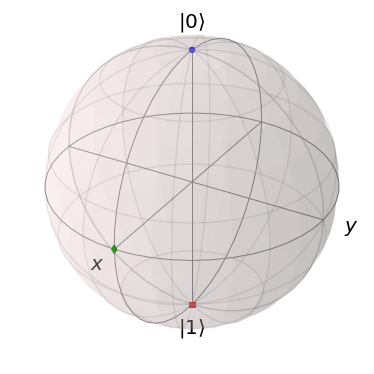

In [4]:
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [5]:
classifier = POVM_clf(n, wires, dev, a_priori_probs, bloch_vecs)

In [ ]:
steps = 600
cost_list = classifier.run_opt(steps)

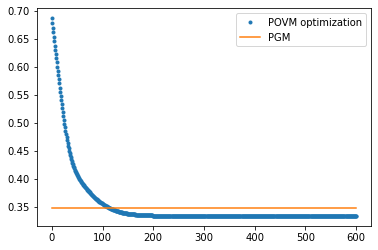

In [7]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
pgm, cost_pgm = classifier.pgm()
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="PGM")
plt.legend()
plt.show()

In [8]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.33333333410895793
performed PGM: 0.34763107293781825


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,1.0000+0.0000j,0.0000+0.0000j,1.0000+0.0000j,-0.0000-0.0000j,,0.7286+0.0000j,-0.1250+0.0000j,
,0.0000+0.0000j,0.0000+0.0000j,-0.0000+0.0000j,0.0000+0.0000j,1.0000,-0.1250+0.0000j,0.0214+0.0000j,0.7286
i=1,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,,0.0214+0.0000j,-0.1250+0.0000j,
,0.0000+0.0000j,1.0000+0.0000j,0.0000-0.0000j,1.0000+0.0000j,1.0000,-0.1250+0.0000j,0.7286+0.0000j,0.7286
i=2,0.5000+0.0000j,0.5000+0.0000j,0.0000+0.0000j,0.0000-0.0000j,,0.2500+0.0000j,0.2500+0.0000j,
,0.5000+0.0000j,0.5000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000,0.2500+0.0000j,0.2500+0.0000j,0.5000


---
# 3. Mixed-state Classifier